## Create the environment, the buffer and the VAE

Create environment.

In [5]:
import gym

env = gym.make("PrivateEye-v4")


/home/qgallouedec/go-explore/env/lib/python3.8/site-packages/gym/envs/registration.py:518: UserWarning: WARN: The environment PrivateEye-v4 is out of date. You should consider upgrading to version `v5` with the environment ID `ALE/PrivateEye-v5`.
  logger.warn(
/home/qgallouedec/go-explore/env/lib/python3.8/site-packages/gym/utils/seeding.py:138: DeprecationWarning: WARN: Function `hash_seed(seed, max_bytes)` is marked as deprecated and will be removed in the future. 
  deprecation(
/home/qgallouedec/go-explore/env/lib/python3.8/site-packages/gym/utils/seeding.py:175: DeprecationWarning: WARN: Function `_bigint_from_bytes(bytes)` is marked as deprecated and will be removed in the future. 
  deprecation(


Choose the device.

In [6]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

Create a buffer and feed it.

In [7]:
import numpy as np

from stable_baselines3.common.buffers import ReplayBuffer


buffer = ReplayBuffer(10000, env.observation_space, env.action_space, device=device)

for episode in range(10):
    done = False
    obs = env.reset()
    while not done:
        action = np.array(env.action_space.sample())
        next_obs, reward, done, info = env.step(action)
        buffer.add(obs, next_obs, action, reward, done, [info])
        obs = next_obs

/home/qgallouedec/go-explore/env/lib/python3.8/site-packages/gym/utils/seeding.py:47: DeprecationWarning: WARN: Function `rng.randint(low, [high, size, dtype])` is marked as deprecated and will be removed in the future. Please use `rng.integers(low, [high, size, dtype])` instead.
  deprecation(


Create a categorical VAE.

In [8]:
from go_explore.categorical_vae import CNNCategoricalVAE

vae = CNNCategoricalVAE().to(device)

## Test the VAE

Sample a batch of observations.

In [9]:
input = buffer.sample(10).observations

Transpose, resize and psuh to the device.

In [10]:
from torchvision.transforms.functional import resize

input = input.moveaxis(-1, -3)
input = resize(input, (129, 129)).float() / 255

Build the reconstruction.

In [11]:
recons, logits = vae(input)

Visualize the result.

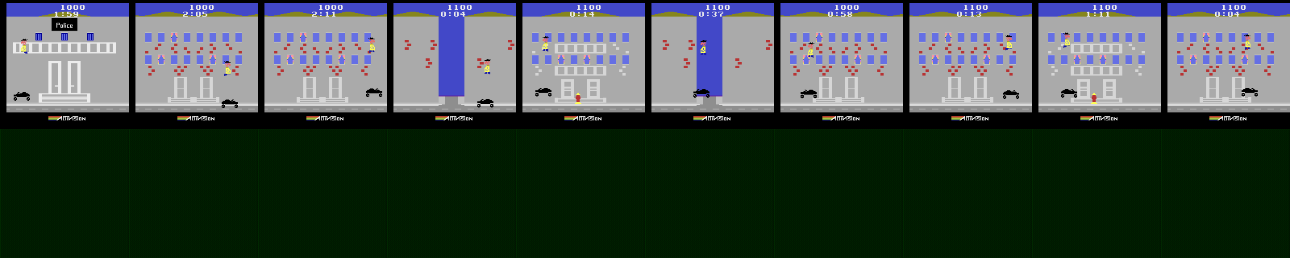

In [12]:
from go_explore.utils import build_image

build_image([input, recons])

Create the loss function.

In [13]:
import torch.nn.functional as F
from typing import Tuple


def loss_func(
    input: torch.Tensor, recons: torch.Tensor, logits: torch.Tensor
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    # Reconstruction loss
    recons_loss = F.mse_loss(input, recons)

    # KL loss
    nb_classes = logits.shape[2]
    probs = F.softmax(logits, dim=2)
    latent_entropy = probs * torch.log(probs + 1e-10)
    target_entropy = probs * torch.log((1.0 / torch.tensor(nb_classes)))
    kl_loss = (latent_entropy - target_entropy).mean()

    # Total loss
    loss = recons_loss + 0.01 * kl_loss
    return loss, recons_loss, kl_loss


Test the loss function.

In [14]:
print(loss_func(input, recons, logits))

(tensor(0.4357, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.4357, device='cuda:0', grad_fn=<MseLossBackward0>), tensor(1.5918e-06, device='cuda:0', grad_fn=<MeanBackward0>))


In [15]:
from torch import optim

buffer_size = 64
optimizer = optim.Adam(vae.parameters(), lr=2e-4)

# Used for visualisation at the end
test_image = buffer.sample(10).observations
test_image = test_image.moveaxis(-1, -3)
test_image = resize(test_image, (129, 129)).float() / 255
images = [test_image]

for epoch in range(5000):
    # Sample
    input = buffer.sample(10).observations
    input = input.moveaxis(-1, -3)
    input = resize(input, (129, 129)).float() / 255

    # Compute the output image
    vae.train()
    recons, logits = vae(input)

    # Compute the loss
    loss, recons_loss, kl_loss = loss_func(input, recons, logits)

    # Step the optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(
            "epoch: {:5d}\tloss: {:.5f}\trecons loss: {:.5f}\tkl loss: {:.5f}".format(
                epoch, loss.item(), recons_loss.item(), kl_loss.item()
            ),
        )
        vae.eval()
        images.append(vae(test_image)[0])


epoch:     0	loss: 0.43898	recons loss: 0.43898	kl loss: 0.00000
epoch:  1000	loss: 0.01147	recons loss: 0.01127	kl loss: 0.01940
epoch:  2000	loss: 0.00657	recons loss: 0.00640	kl loss: 0.01706
epoch:  3000	loss: 0.00482	recons loss: 0.00457	kl loss: 0.02497
epoch:  4000	loss: 0.00458	recons loss: 0.00435	kl loss: 0.02318


Visualize the result. First row is a batch of image from the buffer, and each following row is the reconstruction during the training.

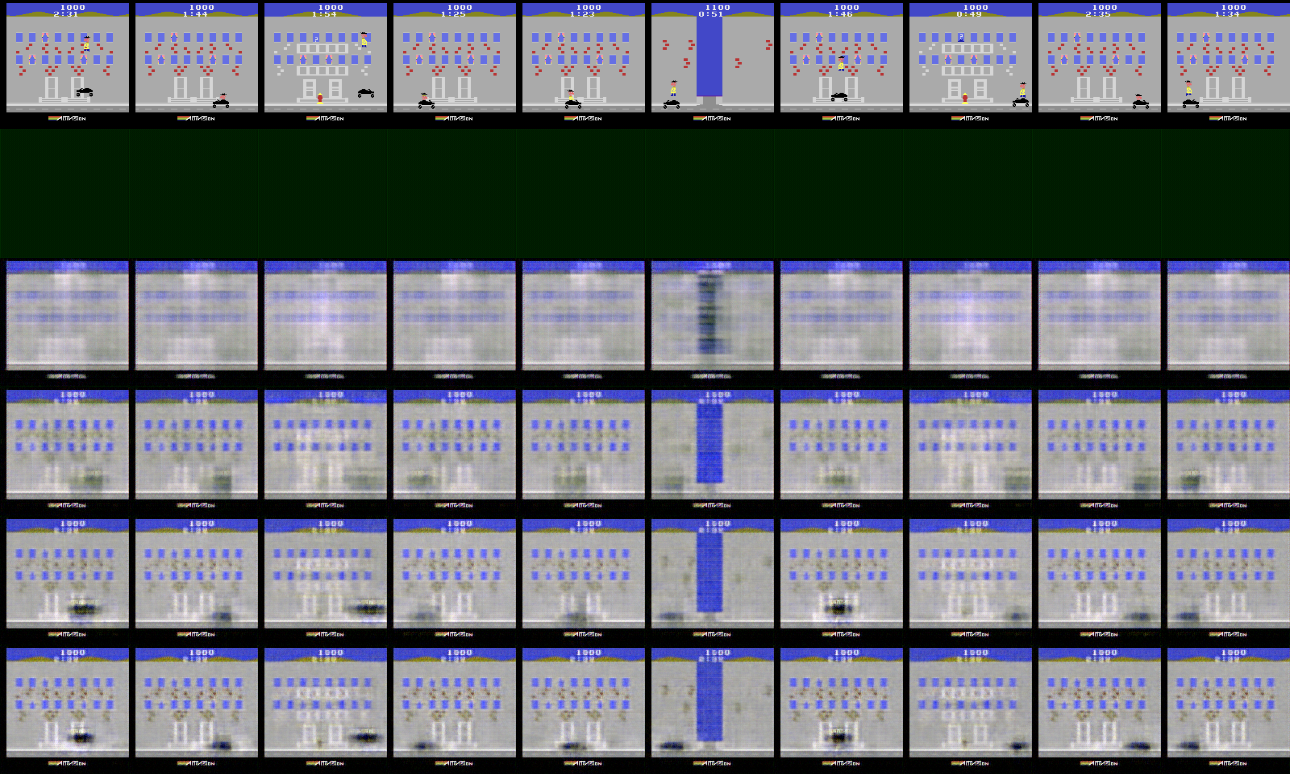

In [16]:
build_image(images)